In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-23 21:06:57.072883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


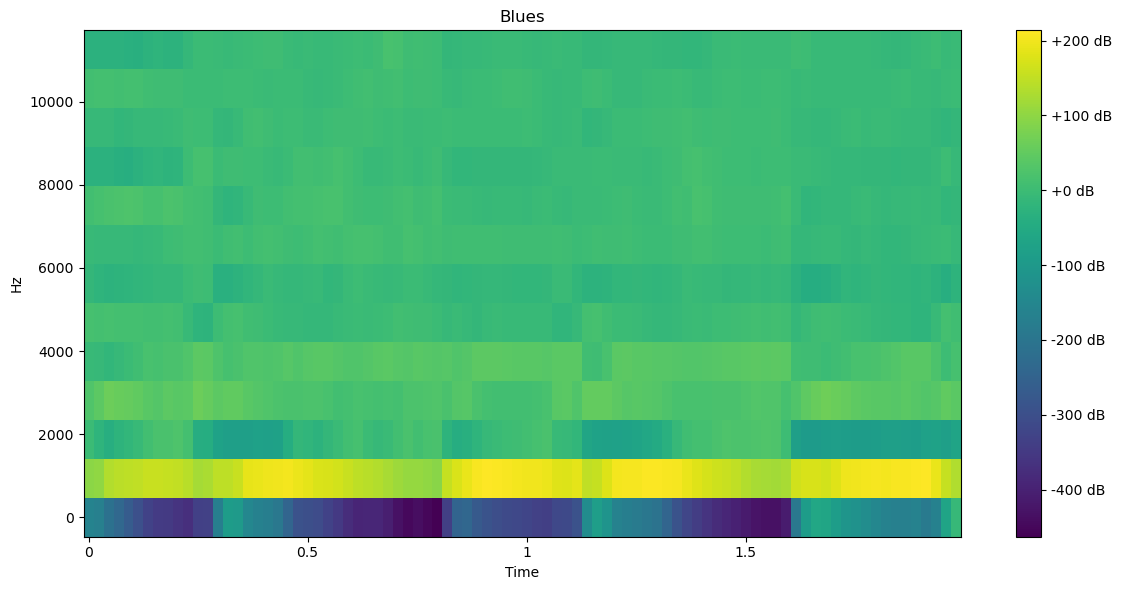

In [4]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_2.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [5]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (8390, 88, 13), y training data shape: (8390,)
X validation data shape: (2098, 88, 13), y validation data shape: (2098,)


In [6]:
model_dnn = Sequential()

model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

model_dnn.summary()

(88, 13)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1144)              0         
                                                                 
 dense (Dense)               (None, 512)               586240    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)        

2025-05-23 21:03:42.430892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250


2025-05-21 16:57:52.271292: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 38392640 exceeds 10% of free system memory.


132/132 [==============================] - 1s 5ms/step - loss: 28.8055 - acc: 0.1342 - val_loss: 3.4597 - val_acc: 0.0882
Epoch 2/250
132/132 [==============================] - 0s 4ms/step - loss: 7.4796 - acc: 0.1380 - val_loss: 3.4233 - val_acc: 0.1225
Epoch 3/250
132/132 [==============================] - 0s 4ms/step - loss: 4.6651 - acc: 0.1275 - val_loss: 3.4308 - val_acc: 0.1111
Epoch 4/250
132/132 [==============================] - 1s 4ms/step - loss: 4.0068 - acc: 0.1263 - val_loss: 3.4308 - val_acc: 0.1044
Epoch 5/250
132/132 [==============================] - 1s 4ms/step - loss: 3.7984 - acc: 0.1130 - val_loss: 3.4288 - val_acc: 0.1034
Epoch 6/250
132/132 [==============================] - 1s 4ms/step - loss: 3.6461 - acc: 0.1164 - val_loss: 3.4261 - val_acc: 0.1030
Epoch 7/250
132/132 [==============================] - 1s 4ms/step - loss: 3.5611 - acc: 0.1136 - val_loss: 3.4229 - val_acc: 0.1030
Epoch 8/250
132/132 [==============================] - 1s 4ms/step - loss: 3.537

141/141 [==============================] - 0s 957us/step - loss: 1.9069 - acc: 0.6426
Test Loss: 1.9068742990493774
Test Accuracy: 0.6425711512565613


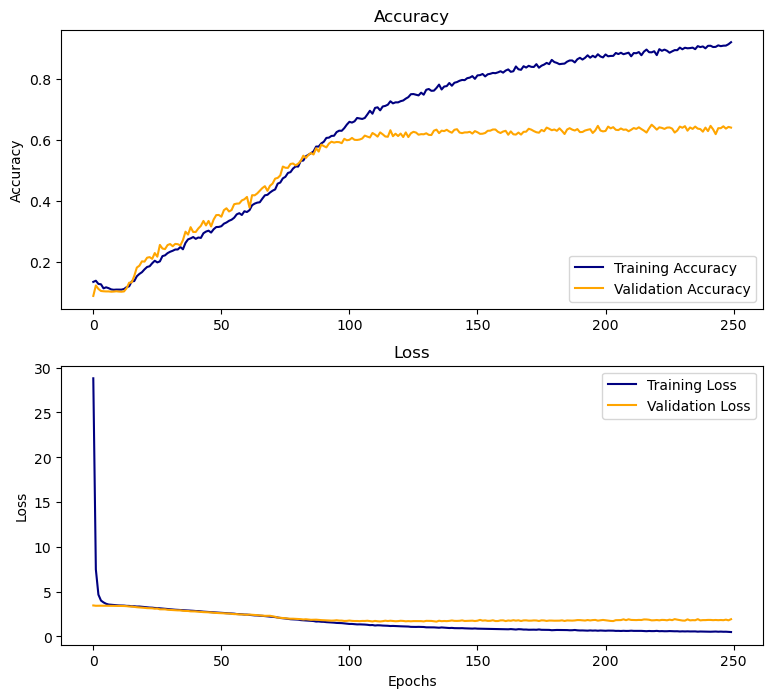

In [10]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")
plot_history(hist_dnn)

In [11]:
preds_num, preds_name = make_prediction(model_dnn, X_test)

1/1 [==============================] - 0s 12ms/step


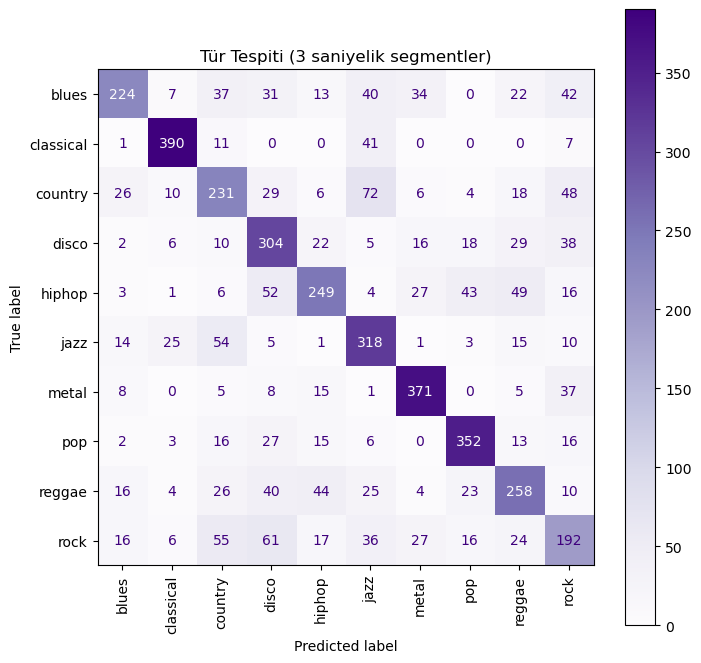

In [12]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [13]:
model_dnn.save(os.path.join(path_prefix, "models/model_dnn.h5"))